<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/pollencounter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 花粉の活性評価
![pollen image](https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/assets/pollencounter/AddFile3/Vv_Pollen_Alcanon.JPG?raw=true)
ぶどう花粉染色図 Tello et al., 2018, Plant Methods

## ライセンス
- Tello et al., 2018, Plant Methods（https://plantmethods.biomedcentral.com/articles/10.1186/s13007-017-0267-2#Sec25） およびAdditionalFile3の花粉染色画像
    - CC-BY 4.0
- 本稿解析コード
    - Apache 2.0

## 解説
花粉の活性度（Viability）は農業形質上重要な尺度となります。花粉の活性度、特にぶどうのそれは最終的な収量に加え、着果率や受粉率を始めとして多くの形質に影響を与えることが知られています。花粉の活性度を簡便に調べるため、筆者らはPollenCounterと呼ばれるImageJのマクロを開発しました。PollenCounterがどのような画像処理をしているか、 論文のAdditional File 2に記載のコードから該当箇所を抜粋し、解説を付け加えました。

```java
1. run("Subtract Background...", "rolling=50 light");
    // RGB型式の入力画像から、背景情報（照明の不均一性やノイズなど）を除去します。
2. run("Split Channels");
    // 画像をRチャンネル,Gチャンネル,Bチャンネルそれぞれ単一の3つのグレースケール画像に分割します。
3-1. red channelに対して以下の処理を適用する
    - setAutoThreshold("Default");
        // 画像をもとにグローバル閾値を自動で求め、二値化によるバイナリー画像を作成します。
    - run("Dilate");　　 // with iteration 5
    - run("Fill Holes");  // with iteration 5
    - run("Erode");  // with iteration 5
        // dilate処理、穴埋め、erode処理で検出領域の穴などを塞ぎます。
    - run("Watershed");  
        // Watershedアルゴリズムで隣接する花粉などを分割します。
    - run("Analyze Particles...", "size=60-800 circularity=0.40-1.00 ..省略");
        //粒子（花粉）の形状や数を計測します。オブジェクト候補のうち、面積が60-800pxのレンジにはいり、かつ真円度が0.4-1.0のもののみを解析対象にします。
3-2. green channelに対して以下の処理を適用する
    - run("Dilate");  // with iteration 5
    - run("Fill Holes");  // with iteration 5
    - run("Erode");  // with iteration 5
    - run("Watershed");
    - run("Analyze Particles...", "size=100-800 circularity=0.40-1.00 ...省略");
        // 同様に粒子（花粉）の形状や数を計測しますが、サイズの閾値がr-channelのそれと異なることに注意。

```
上述のpseudoコードによって得られた結果をもとに、下記２つの式によって評価します。


- Automatic Pollen Viability (APV, 自動測定した花粉生存率)

    - Pollen Grains<sub>G</sub>とPollen Grains<sub>G</sub>は、それぞれGチャンネルとRチャンネルで計測された花粉の数になります。

$$
APV_{\text{img}}(\%) = \frac{Pollen Grains_G}{All Polen Grains_R} \times 100 \
$$


- Pollen Size Index （PSI, 花粉のサイズ指数）
    - 検出できた花粉のうち、サイズ118px以上のものの割合を求めます。
$$
PSI_{\text{img}} (\%) = \frac{PollenGrainsOver118Pixels}{TotalPollenGrains} \times    100 \
$$

大部分がpythonでも容易に再現可能なため、PollenCounterをPythonで再実装してみましょう。

## 実行コード

In [8]:
#画像のダウンロード
!apt install subversion
!svn export https://github.com/phytometrics/plant_phenotyping_python/trunk/notebooks/assets/pollencounter/AddFile3

A    AddFile3
A    AddFile3/Vv_Pollen_Alcanon.JPG
A    AddFile3/Vv_Pollen_Aligote.JPG
A    AddFile3/Vv_Pollen_Beba.JPG
A    AddFile3/Vv_Pollen_Cabernet_Franc.JPG
A    AddFile3/Vv_Pollen_Clairette_Blanche.JPG
A    AddFile3/Vv_Pollen_Muscat_Hamburg.JPG
A    AddFile3/Vv_Pollen_Pedro_Ximenes.JPG
A    AddFile3/Vv_Pollen_Reisling_Weiss.JPG
A    AddFile3/Vv_Pollen_Silvaner_Gruen.JPG
A    AddFile3/Vv_Pollen_Vinhao.JPG
Exported revision 118.


In [64]:
import os
import cv2
import skimage
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

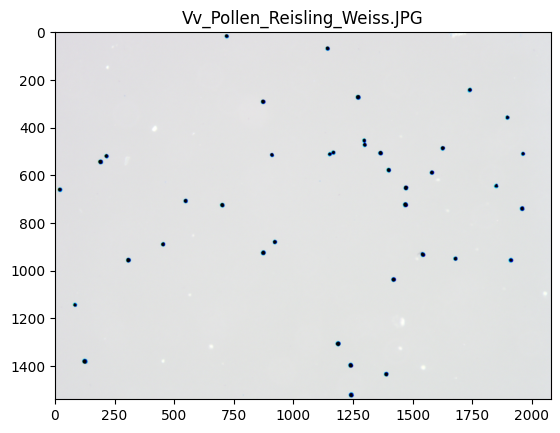

In [67]:
image_dir = "/content/AddFile3"
image_files = os.listdir(image_dir)

image_file = image_files[0]

# 画像読み込み
path = os.path.join(image_dir, image_file)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.title("original image")
plt.title(image_file)
plt.imshow(image)
plt.show()

ImageJの背景除去（subtractBackground）は、グレースケール画像だけでなくカラー画像にも適用可能です。カラー画像の場合、HSB色空間に変換した後、B(Brightness)チャンネルにRolling Ballアルゴリズムを用いて背景除去を実施します。その後、画像はRGB色空間に戻されます。

pythonでは、対応するような機能がskimageやopencvの機能として提供されておらず、自身で実装する必要があります。

下に簡易的な実装をしめします。ただし出力結果を見てわかるように、この実装では１画像の処理に50秒かかってしまいます。目的が照明ムラの除去であること、サンプル画像の照明ムラが最小限であることを考慮し、本稿ではこのステップを省略します。

CPU times: user 55.3 s, sys: 549 ms, total: 55.9 s
Wall time: 55.8 s


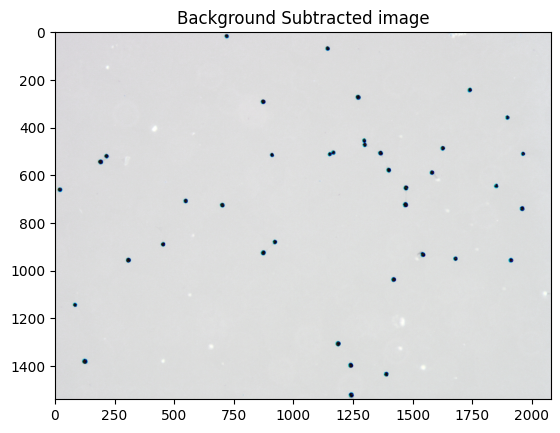

In [94]:
%%time

from skimage.color import rgb2hsv, hsv2rgb
from skimage.morphology import white_tophat, black_tophat, disk

def subtract_background(image, radius=50, background_is_white=True):
    hsb = rgb2hsv(image)  #hsvとhsbは同義
    h, s, b = hsb[...,0], hsb[...,1], hsb[...,2]

    selem = disk(radius)
    if background_is_white:
        background = black_tophat(b, selem)
    else:
        background = white_tophat(b, selem)

    b_corrected = b - background
    hsv_corrected = np.dstack((h, s, b_corrected))
    rgb_corrected = hsv2rgb(hsv_corrected)
    # 0-1から0-255の範囲の画像に戻します。
    rgb_corrected *= 255
    rgb_corrected = rgb_corrected.astype(np.uint8)
    return rgb_corrected

corrected = subtract_background(image)
plt.title("Background Subtracted image")
plt.imshow(corrected)

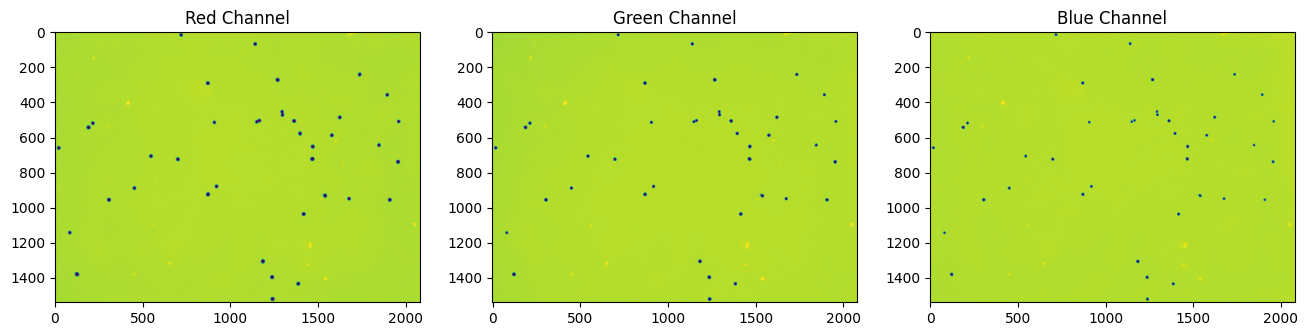

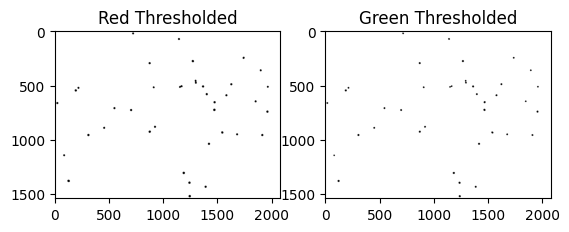

In [95]:
# RGB チャンネルの分割、それぞれのチャンネルで二値化処理。

r_channel, g_channel,  b_channel = image[...,0], image[...,1], image[...,2]
plt.figure(figsize=(16,9))
plt.subplot(1,3,1)
plt.title("Red Channel")
plt.imshow(r_channel)
plt.subplot(1,3,2)
plt.title("Green Channel")
plt.imshow(g_channel)
plt.subplot(1,3,3)
plt.title("Blue Channel")
plt.imshow(b_channel)
plt.show()
# redとgreenのみ使う
r_thresh = threshold_otsu(r_channel)
r_channel = r_channel > r_thresh

g_thresh = threshold_otsu(g_channel)
g_channel = g_channel > g_thresh

plt.subplot(1,2,1)
plt.title("Red Thresholded")
plt.imshow(r_channel, cmap="gray")
plt.subplot(1,2,2)
plt.title("Green Thresholded")
plt.imshow(g_channel, cmap="gray")
plt.show()

In [66]:
from skimage.measure import label, regionprops
import numpy as np

In [96]:
# pythonでは解析対象が白、背景が黒であることを前提とする解析が多いので、白黒逆転させる
r_channel = 255 - r_channel
g_channel = 255 - g_channel

In [101]:
# ImageJのpartical analysisをscikit-imageのregionpropsの機能で代替します。

r_lbl_image = label(r_channel)
r_props = regionprops(r_lbl_image)
print("r channel object no:",len(r_props))
g_lbl_image = label(g_channel)
g_props = regionprops(g_lbl_image)
print("g channel object no:",len(g_props))

r channel object no: 38
g channel object no: 38


In [102]:
# area filtering
# area 60 - 800 px filtering in red channel
r_props = [x for x in r_props if x.area > 60 and x.area < 800]
# area 100 - 800 px filtering in green channel
g_props = [x for x in g_props if x.area > 100 and x.area < 800]

# circularityはregionpropsで算出されないので、別途計算して新しいattributeとして付加する
for prop in r_props:
    circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
    prop.circularity = circularity

for prop in g_props:
    circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
    prop.circularity = circularity

# circularity filtering keep 0.4 -1.00 for both channel
r_props = [x for x in r_props if x.circularity > 0.4 and x.circularity < 1.0]
# area 100 - 800 px filtering in green channel
g_props = [x for x in g_props if x.circularity > 0.4 and x.circularity < 1.0]

print("final r channel object no:",len(r_props))
print("final g channel object no:",len(g_props))

final r channel object no: 37
final g channel object no: 33


というわけで、この画像において、花粉数が37個検出され、その中でも活性のある花粉は33個であることが求められました。これらのコードを１つの関数としてまとめ、全ての画像にたいして解析をしてみましょう。

In [105]:
def pollen_viability_analysis(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 今回は採用しない
    # image = subtract_background(image)

    r_channel, g_channel, _ = image[...,0], image[...,1], image[...,2]

    r_thresh = threshold_otsu(r_channel)
    r_channel = r_channel > r_thresh

    g_thresh = threshold_otsu(g_channel)
    g_channel = g_channel > g_thresh

    r_channel = 255 - r_channel
    g_channel = 255 - g_channel

    r_lbl_image = label(r_channel)
    r_props = regionprops(r_lbl_image)
    g_lbl_image = label(g_channel)
    g_props = regionprops(g_lbl_image)


    r_props = [x for x in r_props if x.area > 60 and x.area < 800]
    g_props = [x for x in g_props if x.area > 100 and x.area < 800]

    # areaでフィルタリングした後の候補領域が残っていた場合のみ２段階目のフィルタリングをかける
    if len(r_props) !=0:
        for prop in r_props:
            circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
            prop.circularity = circularity
        r_props = [x for x in r_props if x.circularity > 0.4 and x.circularity < 1.0]

    if len(r_props) !=0:
        for prop in g_props:
            circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
            prop.circularity = circularity
        g_props = [x for x in g_props if x.circularity > 0.4 and x.circularity < 1.0]

    all_pollen = len(r_props)
    viable_pollen = len(g_props)

    apv = (viable_pollen / all_pollen) * 100

    large = len([x for x in r_props if x.area > 118])
    psi = (large / all_pollen) * 100

    return apv, psi

In [106]:
import pandas as pd

image_dir = "/content/AddFile3"
image_files = os.listdir(image_dir)

results = []

for image_file in image_files:
    path = os.path.join(image_dir, image_file)
    apv, psi = pollen_viability_analysis(path)
    results.append([image_file, apv, psi])

df = pd.DataFrame(results, columns=["image","APV","PSI"])
df

,image,APV,PSI
0,Vv_Pollen_Reisling_Weiss.JPG,89.189189,100.000000
1,Vv_Pollen_Muscat_Hamburg.JPG,85.034014,98.639456
2,Vv_Pollen_Aligote.JPG,76.136364,97.727273
3,Vv_Pollen_Silvaner_Gruen.JPG,77.551020,100.000000
4,Vv_Pollen_Beba.JPG,77.142857,100.000000
5,Vv_Pollen_Clairette_Blanche.JPG,92.187500,100.000000
6,Vv_Pollen_Cabernet_Franc.JPG,86.861314,96.350365
7,Vv_Pollen_Vinhao.JPG,88.392857,100.000000
8,Vv_Pollen_Pedro_Ximenes.JPG,66.666667,100.000000
9,Vv_Pollen_Alcanon.JPG,97.826087,100.000000
